# Filter-and-Fire Neuron Model

## Background

This notebook provide an alternative filter-and-fire pytorch neuron model that might be easier and more robust to use.

In fact, we provide here an implementation of the Exp 3. that was introduced in Filter-and-Fire_Neuron_Model_SNN.ipynb, but wasn't implemented there.

### Experiments conducted (23.7.23)

Note: 
- M: number of connections per presynaptic axon

- Exp 1. M = 1
- Exp 2. M = 3 (Exp 3. of Filter-and-Fire_Neuron_Model_SNN.ipynb)

## Imports

In [1]:
!pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
from scipy import signal

from tqdm.auto import tqdm as pbar

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

## Hyperparameters

In [2]:
# Constants
SECOND = 1
MS = 1e-3
HZ = 1
PI = np.pi
DT = 1*MS # large time step to make simulations run faster

ANF_PER_EAR = 100    # repeats of each ear with independent noise (was 1000 in my other notebooks)
ENVELOPE_POWER = 2   # higher values make sharper envelopes, easier
RATE_MAX = 600*HZ   # maximum Poisson firing rate
F = 20*HZ           # stimulus frequency
DURATION = .1*SECOND # stimulus duration
DURATION_STEPS = int(np.round(DURATION/DT)) # 100
T = np.arange(DURATION_STEPS)*DT # array of times

# Network
INPUT_SIZE = 2*ANF_PER_EAR # 200 input neurons
NUM_HIDDEN = 30
NUM_CLASSES = 180//15 # classes at 15 degree increments
print('Number of classes = {}'.format(NUM_CLASSES))
TAU = 5*MS # this used to be 20 in the SNN Starting Notebook, is now 5 in Quick Start Notebook

# Training
MY_COMPUTER_IS_SLOW = True
if MY_COMPUTER_IS_SLOW:
    BATCH_SIZE = 64
    N_TRAINING_BATCHES = 64
else:
    BATCH_SIZE = 128
    N_TRAINING_BATCHES = 128
N_TESTING_BATCHES = 32
NUM_SAMPLES = BATCH_SIZE*N_TRAINING_BATCHES
BETA = 5 # for Surrogate Gradient Descent
NUM_EPOCHS = 100 # (takes ~6min/epoch with INPUT_SIZE=200)
LR = 0.0001

# Filter-and-Fire Neuron Model (Beniaguev et al., 2022)
NUM_AXONS = 100
CONNECTIONS_PER_AXON = 3
NUM_SYNAPSES = CONNECTIONS_PER_AXON * NUM_AXONS

Number of classes = 12


## Functions

### Stimulus

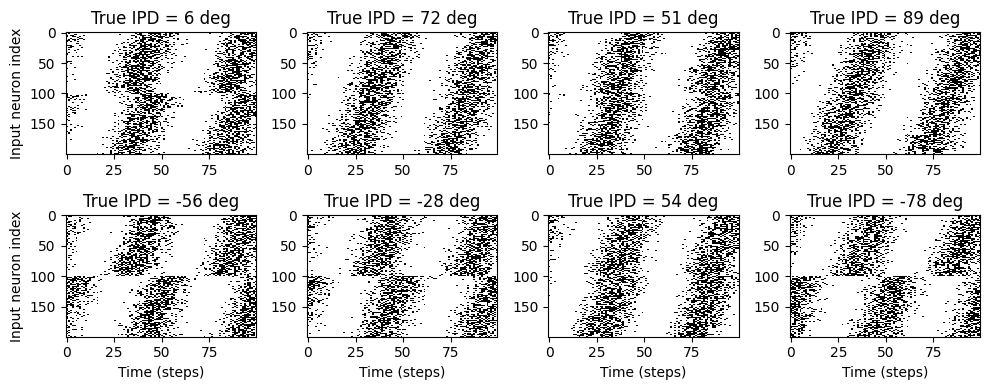

In [3]:
def input_signal(ipd, usual_phase_delays=True):
    """
    Generate an input signal (spike array) from array of true IPDs
  
    Parameters:
    ipd (array): true IPDs
  
    Returns:
    spikes (array): input signal from true IPDs (spike trains)
  
    """
    
    num_samples = len(ipd) # i.e., NUM_SAMPLES
    phi = 2*PI*(F*T+np.random.rand()) # array of phases corresponding to those times with random offset
 
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    if usual_phase_delays: # Exp 1., Exp 2.a
        phase_delays = np.linspace(0, PI/2, ANF_PER_EAR)
    else: # Exp 2.b, Exp 3.
        phase_delays = np.linspace(0, 0, ANF_PER_EAR)

    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<RATE_MAX*DT*(0.5*(1+np.sin(theta)))**ENVELOPE_POWER

    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, usual_phase_delays=True, tensor=True):
    """
    Generate the training data: true IPDs are in U(-pi/2, pi/2) 
  
    Parameters:
    num_samples (int)
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    tensor (boolean): flag on the use of tensor or numpy objects for the objects returned
  
    Returns:
    ipd (array): true IPDs from U(-pi/2, pi/2)
    spikes (array): input signal corresponding to the true IPDs in the training data
  
    """

    ipd = np.random.rand(num_samples)*PI-PI/2 # uniformly random in (-pi/2, pi/2)
    #print(ipd)# okay
    spikes = input_signal(ipd, usual_phase_delays)
    #print(spikes) # empty
    
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        
    return ipd, spikes


def discretise(ipds):
    """
    Discretise the ipds in the training data 
  
    Parameters:
    ipds (tensor)
  
    Returns:
    tensor
  
    """
    return ((ipds+PI/2)*NUM_CLASSES/PI).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
    Undo the discretisation of ipds
  
    Parameters:
    ipd_indices (array)
  
    Returns:
    array
  
    """
    return (ipd_indices+0.5)/NUM_CLASSES*PI-PI/2


# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate the whole training data by iterating over the data in the batches.
    Order of the data is randomly permuted to improve learning.
  
    Parameters:
    ipds (tensor)
    spikes (tensor): flag on the use of usual or null phase delays
  
    Yields:
    x_local (tensor): relates to the spikes
    y_local (tensor): relates to the ipds
  
    """
    
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//BATCH_SIZE
    
    for i in range(n_batch):
        x_local = spikes[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        y_local = ipds[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        yield x_local, y_local

# Plot a few just to show how it looks
def plot_some_input_examples(num_examples=8):
    """
    Plots some example inputs.
  
    Parameters:
    num_examples (int): default = 8
  
    """
    
    ipd, spikes = random_ipd_input_signal(num_examples)
    spikes = spikes.cpu()
    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(num_examples):
        plt.subplot(2, 4, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/PI)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
        plt.tight_layout()
    
    
plot_some_input_examples()

### SNN

In [4]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*BETA*torch.sigmoid(BETA*input)*(1-torch.sigmoid(BETA*input))
        return grad

spike_fn  = SurrGradSpike.apply

# Run the simulation
def snn(presynaptic_input_spikes_tensor, W1, W1_bis, W2, 
        multiple_connections_per_axon, single_neuron_model):
    
    """
    Runs the SNN simulation.
  
    Parameters:
    presynaptic_input_spikes_tensor (tensor): corresponds to x_local in the training
    W1 (tensor): initialised trainable weight parameter for the first layer
    W2 (tensor): initialised trainable weight parameter for the second layer
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon,
    single_neuron_model (function): a function that computes the output of a single neuron, given input over multiple segments
  
    Returns:
    v_rec (tensor): recorded membrane potential of output
    input_smoothed (tensor): smoothed inputs
  
    """
    
    # First layer: input to hidden
    v = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]

    cur_connections_per_axon = CONNECTIONS_PER_AXON if multiple_connections_per_axon else 1

    inputs_for_all_segments_of_all_hidden = (presynaptic_input_spikes_tensor @ W1)

    # BATCH_SIZE, DURATION_STEPS, NUM_HIDDEN * cur_connections_per_axon

    inputs_for_all_segments_of_all_hidden = inputs_for_all_segments_of_all_hidden.transpose(1,2)

    # BATCH_SIZE, NUM_HIDDEN * cur_connections_per_axon, DURATION_STEPS

    inputs_for_all_segments_of_all_hidden_for_single_neuron = inputs_for_all_segments_of_all_hidden.reshape(BATCH_SIZE * NUM_HIDDEN, cur_connections_per_axon, DURATION_STEPS)

    # BATCH_SIZE * NUM_HIDDEN, cur_connections_per_axon, DURATION_STEPS

    # we use a handy trick here, enlarging the batch size, so we can use a single neuron model for all the neurons in the hidden layer
    hidden_output = single_neuron_model(inputs_for_all_segments_of_all_hidden_for_single_neuron)

    # BATCH_SIZE * NUM_HIDDEN, DURATION_STEPS

    hidden_output = hidden_output.reshape(BATCH_SIZE, NUM_HIDDEN, DURATION_STEPS)
    
    s_rec = hidden_output.transpose(1,2)

    # Second layer: hidden to output
    v = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-DT/TAU)
    for t in range(DURATION_STEPS - 1):  
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    
    # Return recorded membrane potential of output and smoothed input (for visualisation)
    return v_rec

### Training

In [5]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    """
    Initialises the weight matrix used in the fanin-fanout calculations for the initialisation of W1 and W2.
  
    Parameters:
    None
    
    Returns:
    W (tensor): weight tensor used in fanin-fanout calculations
  
    """

    W = nn.Parameter(torch.empty((INPUT_SIZE, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    
    return W

def init_weight_matrices(W, multiple_connections_per_axon=False):
    """
    Initialises the weight matrices in the SNN: W1, W1_bis and W2.
  
    Parameters:
    W (tensor): weight tensor used in fanin-fanout calculations for W1 and W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
  
    Returns:
    W1 (tensor): initialised trainable weight parameter for the first layer
    W1_bis (tensor): fixed non-trainable weight parameter for the first layer when there are multiple connections per axon
    W2 (tensor): initialised trainable weight parameter for the second layer
  
    """
    
    if multiple_connections_per_axon: # Exp. 3
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN*CONNECTIONS_PER_AXON), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
    
        # placeholder for W1_bis (not used)
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    else:
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
        
        # placeholder for W1_bis (not used)
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    return W1, W1_bis, W2
    
    
def train(ipds, spikes, usual_phase_delays=True, multiple_connections_per_axon=False, random_tau_constants=False, minimal_smoothing=False):
    """
    Runs the training of the SNN simulation.
  
    Parameters:
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    ipds (tensor): training data (y)
    spikes (tensor): training data (X)
    W1 (tensor): trained W1
    W2 (tensor): trained W2
    snn_training_snapshot (list): snapshots of the training at each epoch
  
    """
    
    # Generate the training data
    #ipds, spikes = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays)
    
    # Initialise weight matrices
    W = init_weight_matrix() # for fan_in/out calculations
    W1, W1_bis, W2 = init_weight_matrices(W, multiple_connections_per_axon)

    # Optimiser and loss function
    optimizer = torch.optim.Adam([W1, W2], lr=LR)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    snn_training_snapshot = []

    # TODO: plug all of these parameters inside: random_tau_constants, minimal_smoothing, currently they are being ignored
    single_neuron_model = FilterAndFireNeuron(count_segments=CONNECTIONS_PER_AXON if multiple_connections_per_axon else 1)
    
    for e in pbar(range(NUM_EPOCHS)):
        
        local_loss = []
        batch_number = 0
        
        print('--------------------------------------------------------')
        print("EPOCH {}".format(e+1))
        
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            
            batch_number += 1
            
            # Run network
            output = snn(x_local, W1, W1_bis, W2, multiple_connections_per_axon, single_neuron_model)
            
            # Compute cross entropy loss
            #m = torch.sum(output, 1)*0.01  # Sum time dimension
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension

            reg = 0 # to add regularisation later if wanted
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Record and print the loss of the current epoch
        loss_hist.append(np.mean(local_loss))
        print("---EPOCH %i: LOSS=%.5f"%(e+1, np.mean(local_loss)))

        # Plot raster plot: 
        # e.g. input_smoothed for the 1st example of the last batch of the current epoch
        #print("---Raster Plots at Epoch {} - Example #1/64 of the Last Batch Group".format(e+1))
        #plt.figure(1)
        #plt.title("input_smoothed example vs corresponding initial spike train")
        #plt.subplot(211)
        #plt.imshow(input_smoothed[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
        #plt.subplot(212)
        #plt.imshow(x_local[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
    
        #plt.show()
        
        # Take a snapshot of the model at the end of the current epoch. 
        ## Use cases:
        ### if we want to resume training from this current epoch,
        ### or if the training is halted before the last epoch
        snn_training_snapshot.append({'W1':W1, 'W2':W2, 
                                      'multiple_connections_per_axon':multiple_connections_per_axon, 
                                      'random_tau_constants':random_tau_constants, 
                                      'minimal_smoothing':minimal_smoothing}) 
        
    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    # return the train dataset (ipds, spikes) and trained weights for analysis
    # also return the list of model snapshots for each epoch (in case we want to resume training)
    return W1, W1_bis, W2, snn_training_snapshot, single_neuron_model


### Train and Test Performance of the Trained Model 

In [6]:
def get_accuracy(ipds, spikes, run):
    """
    Gets the accuracy on data (train or test)
  
    Parameters:
    ipds (tensor)
    spikes (tensor)
    run (lambda function)
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    
    #print(ipds.shape)
    #print(spikes.shape)
    
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        #m = torch.sum(output, 1)  # Sum time dimension
        m = torch.mean(output, 1)
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
            
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):
    """
    Plots the accuracy on data (train or test).
  
    Parameters:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
    label (string): "Test" or "Train"
  
    Returns:
    None
  
    """

    abs_errors_deg = abs(ipd_true-ipd_est)*180/PI

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / PI, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / PI, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

def analyse_accuracy(ipds, spikes, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon, single_neuron_model, test_data=False):
    """
    Analyses the accuracy on data (train or test)
  
    Parameters:
    ipds_train (tensor)
    spikes_train (tensor)
    W1_trained (tensor): trained W1
    W2_trained (tensor): trained W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
    test_data (boolean): flag on the use of test data for the analysis of the accuracy
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    run_function = lambda x: snn(x, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon, single_neuron_model)
    
    ipd_true, ipd_est, confusion, accs = get_accuracy(ipds, spikes, run_function)
    
    # Analyse test accuracy
    if test_data: 
        label = "Test"
    # Analyse train accuracy
    else:
        label = "Train"

    report_accuracy(ipd_true, ipd_est, confusion, accs, label)

    return 100*np.mean(accs)


### Alternative Filter-and-Fire Neuron Model

In [7]:
def create_psp_filter(temporal_length, tau_rise, tau_decay):
    safety_factor = 1.5
    if tau_rise >= (tau_decay / safety_factor):
        tau_decay = safety_factor * tau_rise

    exp_r = signal.exponential(temporal_length, 0, tau_rise, sym=False)
    exp_d = signal.exponential(temporal_length, 0, tau_decay, sym=False)
    post_syn_potential = exp_d - exp_r
    post_syn_potential = post_syn_potential / np.max(post_syn_potential)
    post_syn_potential = np.flipud(post_syn_potential)
    return post_syn_potential

class PostSynapticPotentials(nn.Module):
    def __init__(self, tau_rise_vec, tau_decay_vec):
        super().__init__()

        self.count_filters = len(tau_rise_vec)
        self.tau_rise_vec = tau_rise_vec
        self.tau_decay_vec = tau_decay_vec
        self.temporal_filter_length = int(4 * np.max(tau_decay_vec)) + 1

        temporal_filters = torch.zeros(self.count_filters, self.temporal_filter_length)
        for i in range(self.count_filters):
            temporal_filters[i, :] = torch.tensor(
                create_psp_filter(self.temporal_filter_length, tau_rise_vec[i],
                 tau_decay_vec[i]).copy(), dtype=torch.float)

        self.temporal_filters = nn.Parameter(temporal_filters, requires_grad=False)

    def forward(self, x):
        # 0 batch size, 1 channel_shape, 2 time
        batch_size = x.shape[0]
        x_time = x.shape[-1]
        x_channel_shape = tuple(x.shape[1:-1])
        x_channel_dim = np.prod(x_channel_shape)

        if len(x_channel_shape) > 1:
            # TODO: implement one day
            raise ValueError('The input tensor must be 3 dimensional.')

        if x_channel_dim != self.count_filters:
            raise ValueError('The number of channels in the input tensor does not match the number of filters.')

        x = x.reshape(-1, x_channel_dim, x.shape[-1])
        x = torch.concat([torch.zeros(x.shape[0], x.shape[1], self.temporal_filter_length).to(x.device), x], dim=2)
        filtered = torch.nn.functional.conv1d(x.float(), self.temporal_filters.unsqueeze(1).float(), padding=self.temporal_filter_length, groups=self.count_filters)[:,:,self.temporal_filter_length+1:-self.temporal_filter_length]
        filtered = filtered.reshape(batch_size, x_channel_dim, x_time)

        return filtered

In [8]:
class FilterAndFireNeuron(nn.Module):
    def __init__(self, count_segments=5, tau_rise_range=[1, 16], tau_decay_range=[8, 30],
                 sort_tau_rise=False, sort_tau_decay=False, tau_rise_vec=None, tau_decay_vec=None,
                 return_currents=False, return_voltage=False):
        super().__init__()

        self.count_axons = 1

        if tau_rise_vec is not None and tau_decay_vec is not None:
            if len(tau_rise_vec) != len(tau_decay_vec):
                raise ValueError('tau_rise_vec and tau_decay_vec must have the same length.')

            self.count_segments = len(tau_rise_vec) // self.count_axons

            self.effective_tau_rise_vec = tau_rise_vec
            self.effective_tau_decay_vec = tau_decay_vec
            self.psps = PostSynapticPotentials(tau_rise_vec, tau_decay_vec)

            self.count_synapses = self.count_axons * self.count_segments

        elif tau_rise_range is not None and tau_decay_range is not None and count_segments is not None:
            self.count_segments = count_segments
            self.count_synapses = self.count_axons * self.count_segments

            # repeat the same filter for each axon
            tau_rise_vec = np.random.uniform(tau_rise_range[0], tau_rise_range[1], self.count_synapses)
            if sort_tau_rise:
                # sort the tau_rise_vec to make sure that the first element is the largest
                tau_rise_vec = np.sort(tau_rise_vec)[::-1]

            tau_decay_vec = np.random.uniform(tau_decay_range[0], tau_decay_range[1], self.count_synapses)
            if sort_tau_decay:
                # sort the tau_decay_vec to make sure that the first element is the largest
                tau_decay_vec = np.sort(tau_decay_vec)[::-1]

            self.effective_tau_rise_vec = tau_rise_vec
            self.effective_tau_decay_vec = tau_decay_vec
            self.psps = PostSynapticPotentials(self.effective_tau_rise_vec, self.effective_tau_decay_vec)

        else:
            raise ValueError('Either tau_rise_vec and tau_decay_vec or tau_rise_range and tau_decay_range and count_segments must be specified.')

        self.return_currents = return_currents
        self.return_voltage = return_voltage

    def forward(self, x):
        batch_size = x.shape[0]
        x_time = x.shape[-1]
        x_channel_shape = tuple(x.shape[1:-1])
        x_channel_dim = np.prod(x_channel_shape)

        x = x.reshape(batch_size, x_channel_dim, x_time)

        if x_channel_dim != self.count_segments:
            raise ValueError('The number of channels does not match the number of segments.')

        currents = self.psps(x)

        if self.return_currents:
            return currents            

        # sum over synapses
        somatic_current = torch.sum(currents, dim=1)

        # a naive approach for now (might want to have a resting membrane potential and a resistance)
        somatic_voltage = somatic_current

        v = torch.zeros(somatic_voltage.shape, device=device, dtype=dtype)
        s = torch.zeros(somatic_voltage.shape, device=device, dtype=dtype)

        alpha = np.exp(-DT/TAU)
        for t in range(DURATION_STEPS - 1):
            v[:, t+1] = (alpha*v[:, t] + somatic_voltage[:, t])*(1-s[:, t]) # multiply by 0 after a spike (similar to soma_current) 
            s[:, t+1] = spike_fn(v[:, t+1]-1) # threshold of 1

        if self.return_voltage:
            return v

        return s
    
    def get_model_shape(self):
        return ((self.count_segments,), True, (1,), 0, 0.5)

Note: if the network performs at chance, the accuracy should be 1 out of 12 (since there are 12 classes).

## Exp 1. Training & Testing Results

### Using no multiple connections (M=1)

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1


  1%|          | 1/100 [00:06<10:45,  6.52s/it]

---EPOCH 1: LOSS=2.80819
--------------------------------------------------------
EPOCH 2


  2%|▏         | 2/100 [00:13<10:42,  6.55s/it]

---EPOCH 2: LOSS=2.56571
--------------------------------------------------------
EPOCH 3


  3%|▎         | 3/100 [00:19<10:44,  6.65s/it]

---EPOCH 3: LOSS=2.46367
--------------------------------------------------------
EPOCH 4


  4%|▍         | 4/100 [00:27<10:59,  6.87s/it]

---EPOCH 4: LOSS=2.39239
--------------------------------------------------------
EPOCH 5


  5%|▌         | 5/100 [00:34<10:55,  6.90s/it]

---EPOCH 5: LOSS=2.34705
--------------------------------------------------------
EPOCH 6


  6%|▌         | 6/100 [00:40<10:35,  6.76s/it]

---EPOCH 6: LOSS=2.30928
--------------------------------------------------------
EPOCH 7


  7%|▋         | 7/100 [00:47<10:28,  6.76s/it]

---EPOCH 7: LOSS=2.27508
--------------------------------------------------------
EPOCH 8


  8%|▊         | 8/100 [00:53<10:11,  6.64s/it]

---EPOCH 8: LOSS=2.24177
--------------------------------------------------------
EPOCH 9


  9%|▉         | 9/100 [01:00<10:11,  6.72s/it]

---EPOCH 9: LOSS=2.21162
--------------------------------------------------------
EPOCH 10


 10%|█         | 10/100 [01:08<10:30,  7.01s/it]

---EPOCH 10: LOSS=2.18304
--------------------------------------------------------
EPOCH 11


 11%|█         | 11/100 [01:15<10:20,  6.98s/it]

---EPOCH 11: LOSS=2.15678
--------------------------------------------------------
EPOCH 12


 12%|█▏        | 12/100 [01:22<10:14,  6.98s/it]

---EPOCH 12: LOSS=2.13329
--------------------------------------------------------
EPOCH 13


 13%|█▎        | 13/100 [01:29<10:08,  6.99s/it]

---EPOCH 13: LOSS=2.11015
--------------------------------------------------------
EPOCH 14


 14%|█▍        | 14/100 [01:35<09:54,  6.91s/it]

---EPOCH 14: LOSS=2.08944
--------------------------------------------------------
EPOCH 15


 15%|█▌        | 15/100 [01:43<10:10,  7.18s/it]

---EPOCH 15: LOSS=2.06968
--------------------------------------------------------
EPOCH 16


 16%|█▌        | 16/100 [01:50<10:00,  7.15s/it]

---EPOCH 16: LOSS=2.05117
--------------------------------------------------------
EPOCH 17


 17%|█▋        | 17/100 [01:57<09:46,  7.07s/it]

---EPOCH 17: LOSS=2.03224
--------------------------------------------------------
EPOCH 18


 18%|█▊        | 18/100 [02:04<09:34,  7.00s/it]

---EPOCH 18: LOSS=2.01423
--------------------------------------------------------
EPOCH 19


 19%|█▉        | 19/100 [02:11<09:24,  6.97s/it]

---EPOCH 19: LOSS=1.99642
--------------------------------------------------------
EPOCH 20


 20%|██        | 20/100 [02:18<09:18,  6.99s/it]

---EPOCH 20: LOSS=1.97965
--------------------------------------------------------
EPOCH 21


 21%|██        | 21/100 [02:25<09:07,  6.94s/it]

---EPOCH 21: LOSS=1.96248
--------------------------------------------------------
EPOCH 22


 22%|██▏       | 22/100 [02:32<08:59,  6.92s/it]

---EPOCH 22: LOSS=1.94670
--------------------------------------------------------
EPOCH 23


 23%|██▎       | 23/100 [02:39<09:00,  7.02s/it]

---EPOCH 23: LOSS=1.93074
--------------------------------------------------------
EPOCH 24


 24%|██▍       | 24/100 [02:46<09:07,  7.20s/it]

---EPOCH 24: LOSS=1.91624
--------------------------------------------------------
EPOCH 25


 25%|██▌       | 25/100 [02:53<08:55,  7.15s/it]

---EPOCH 25: LOSS=1.90246
--------------------------------------------------------
EPOCH 26


 26%|██▌       | 26/100 [03:00<08:45,  7.10s/it]

---EPOCH 26: LOSS=1.88736
--------------------------------------------------------
EPOCH 27


 27%|██▋       | 27/100 [03:08<08:38,  7.10s/it]

---EPOCH 27: LOSS=1.87312
--------------------------------------------------------
EPOCH 28


 28%|██▊       | 28/100 [03:15<08:31,  7.10s/it]

---EPOCH 28: LOSS=1.85814
--------------------------------------------------------
EPOCH 29


 29%|██▉       | 29/100 [03:22<08:32,  7.22s/it]

---EPOCH 29: LOSS=1.84455
--------------------------------------------------------
EPOCH 30


 30%|███       | 30/100 [03:29<08:14,  7.07s/it]

---EPOCH 30: LOSS=1.83083
--------------------------------------------------------
EPOCH 31


 31%|███       | 31/100 [03:36<07:59,  6.95s/it]

---EPOCH 31: LOSS=1.81682
--------------------------------------------------------
EPOCH 32


 32%|███▏      | 32/100 [03:43<07:58,  7.03s/it]

---EPOCH 32: LOSS=1.80451
--------------------------------------------------------
EPOCH 33


 33%|███▎      | 33/100 [03:50<07:54,  7.09s/it]

---EPOCH 33: LOSS=1.79022
--------------------------------------------------------
EPOCH 34


 34%|███▍      | 34/100 [03:57<07:45,  7.05s/it]

---EPOCH 34: LOSS=1.77817
--------------------------------------------------------
EPOCH 35


 35%|███▌      | 35/100 [04:04<07:37,  7.04s/it]

---EPOCH 35: LOSS=1.76454
--------------------------------------------------------
EPOCH 36


 36%|███▌      | 36/100 [04:11<07:28,  7.01s/it]

---EPOCH 36: LOSS=1.75081
--------------------------------------------------------
EPOCH 37


 37%|███▋      | 37/100 [04:19<07:34,  7.22s/it]

---EPOCH 37: LOSS=1.73887
--------------------------------------------------------
EPOCH 38


 38%|███▊      | 38/100 [04:25<07:21,  7.12s/it]

---EPOCH 38: LOSS=1.72622
--------------------------------------------------------
EPOCH 39


 39%|███▉      | 39/100 [04:32<07:09,  7.05s/it]

---EPOCH 39: LOSS=1.71504
--------------------------------------------------------
EPOCH 40


 40%|████      | 40/100 [04:40<07:06,  7.12s/it]

---EPOCH 40: LOSS=1.70258
--------------------------------------------------------
EPOCH 41


 41%|████      | 41/100 [04:46<06:50,  6.96s/it]

---EPOCH 41: LOSS=1.69242
--------------------------------------------------------
EPOCH 42


 42%|████▏     | 42/100 [04:54<06:49,  7.06s/it]

---EPOCH 42: LOSS=1.68099
--------------------------------------------------------
EPOCH 43


 43%|████▎     | 43/100 [05:00<06:38,  6.99s/it]

---EPOCH 43: LOSS=1.66983
--------------------------------------------------------
EPOCH 44


 44%|████▍     | 44/100 [05:07<06:29,  6.96s/it]

---EPOCH 44: LOSS=1.65832
--------------------------------------------------------
EPOCH 45


 45%|████▌     | 45/100 [05:14<06:21,  6.94s/it]

---EPOCH 45: LOSS=1.64753
--------------------------------------------------------
EPOCH 46


 46%|████▌     | 46/100 [05:21<06:12,  6.90s/it]

---EPOCH 46: LOSS=1.63689
--------------------------------------------------------
EPOCH 47


 47%|████▋     | 47/100 [05:28<06:05,  6.89s/it]

---EPOCH 47: LOSS=1.62782
--------------------------------------------------------
EPOCH 48


 48%|████▊     | 48/100 [05:34<05:53,  6.79s/it]

---EPOCH 48: LOSS=1.61655
--------------------------------------------------------
EPOCH 49


 49%|████▉     | 49/100 [05:42<05:53,  6.94s/it]

---EPOCH 49: LOSS=1.60632
--------------------------------------------------------
EPOCH 50


 50%|█████     | 50/100 [05:49<05:46,  6.92s/it]

---EPOCH 50: LOSS=1.59681
--------------------------------------------------------
EPOCH 51


 51%|█████     | 51/100 [05:55<05:37,  6.89s/it]

---EPOCH 51: LOSS=1.58720
--------------------------------------------------------
EPOCH 52


 52%|█████▏    | 52/100 [06:02<05:27,  6.83s/it]

---EPOCH 52: LOSS=1.57817
--------------------------------------------------------
EPOCH 53


 53%|█████▎    | 53/100 [06:09<05:17,  6.75s/it]

---EPOCH 53: LOSS=1.56839
--------------------------------------------------------
EPOCH 54


 54%|█████▍    | 54/100 [06:15<05:06,  6.67s/it]

---EPOCH 54: LOSS=1.55952
--------------------------------------------------------
EPOCH 55


 55%|█████▌    | 55/100 [06:21<04:56,  6.58s/it]

---EPOCH 55: LOSS=1.55179
--------------------------------------------------------
EPOCH 56


 56%|█████▌    | 56/100 [06:28<04:49,  6.58s/it]

---EPOCH 56: LOSS=1.54211
--------------------------------------------------------
EPOCH 57


 57%|█████▋    | 57/100 [06:35<04:42,  6.56s/it]

---EPOCH 57: LOSS=1.53133
--------------------------------------------------------
EPOCH 58


 58%|█████▊    | 58/100 [06:41<04:35,  6.55s/it]

---EPOCH 58: LOSS=1.52345
--------------------------------------------------------
EPOCH 59


 59%|█████▉    | 59/100 [06:48<04:27,  6.53s/it]

---EPOCH 59: LOSS=1.51453
--------------------------------------------------------
EPOCH 60


 60%|██████    | 60/100 [06:54<04:18,  6.47s/it]

---EPOCH 60: LOSS=1.50648
--------------------------------------------------------
EPOCH 61


 61%|██████    | 61/100 [07:01<04:14,  6.52s/it]

---EPOCH 61: LOSS=1.49838
--------------------------------------------------------
EPOCH 62


 62%|██████▏   | 62/100 [07:07<04:07,  6.50s/it]

---EPOCH 62: LOSS=1.48960
--------------------------------------------------------
EPOCH 63


 63%|██████▎   | 63/100 [07:14<04:01,  6.53s/it]

---EPOCH 63: LOSS=1.48082
--------------------------------------------------------
EPOCH 64


 64%|██████▍   | 64/100 [07:21<03:59,  6.64s/it]

---EPOCH 64: LOSS=1.47425
--------------------------------------------------------
EPOCH 65


 65%|██████▌   | 65/100 [07:28<04:00,  6.86s/it]

---EPOCH 65: LOSS=1.46543
--------------------------------------------------------
EPOCH 66


 66%|██████▌   | 66/100 [07:35<03:58,  7.02s/it]

---EPOCH 66: LOSS=1.45702
--------------------------------------------------------
EPOCH 67


 67%|██████▋   | 67/100 [07:43<03:54,  7.11s/it]

---EPOCH 67: LOSS=1.44927
--------------------------------------------------------
EPOCH 68


 68%|██████▊   | 68/100 [07:49<03:41,  6.91s/it]

---EPOCH 68: LOSS=1.44185
--------------------------------------------------------
EPOCH 69


 69%|██████▉   | 69/100 [07:55<03:28,  6.73s/it]

---EPOCH 69: LOSS=1.43385
--------------------------------------------------------
EPOCH 70


 70%|███████   | 70/100 [08:02<03:21,  6.72s/it]

---EPOCH 70: LOSS=1.42711
--------------------------------------------------------
EPOCH 71


 71%|███████   | 71/100 [08:09<03:13,  6.67s/it]

---EPOCH 71: LOSS=1.41897
--------------------------------------------------------
EPOCH 72


 72%|███████▏  | 72/100 [08:16<03:12,  6.87s/it]

---EPOCH 72: LOSS=1.41135
--------------------------------------------------------
EPOCH 73


 73%|███████▎  | 73/100 [08:24<03:11,  7.11s/it]

---EPOCH 73: LOSS=1.40472
--------------------------------------------------------
EPOCH 74


 74%|███████▍  | 74/100 [08:30<03:02,  7.03s/it]

---EPOCH 74: LOSS=1.39800
--------------------------------------------------------
EPOCH 75


 75%|███████▌  | 75/100 [08:37<02:52,  6.90s/it]

---EPOCH 75: LOSS=1.39094
--------------------------------------------------------
EPOCH 76


 76%|███████▌  | 76/100 [08:43<02:38,  6.61s/it]

---EPOCH 76: LOSS=1.38453
--------------------------------------------------------
EPOCH 77


 77%|███████▋  | 77/100 [08:50<02:34,  6.71s/it]

---EPOCH 77: LOSS=1.37715
--------------------------------------------------------
EPOCH 78


 78%|███████▊  | 78/100 [08:56<02:24,  6.57s/it]

---EPOCH 78: LOSS=1.37000
--------------------------------------------------------
EPOCH 79


 79%|███████▉  | 79/100 [09:02<02:12,  6.33s/it]

---EPOCH 79: LOSS=1.36330
--------------------------------------------------------
EPOCH 80


 80%|████████  | 80/100 [09:07<02:00,  6.05s/it]

---EPOCH 80: LOSS=1.35700
--------------------------------------------------------
EPOCH 81


 81%|████████  | 81/100 [09:14<01:59,  6.27s/it]

---EPOCH 81: LOSS=1.34961
--------------------------------------------------------
EPOCH 82


 82%|████████▏ | 82/100 [09:21<01:57,  6.53s/it]

---EPOCH 82: LOSS=1.34357
--------------------------------------------------------
EPOCH 83


 83%|████████▎ | 83/100 [09:28<01:52,  6.59s/it]

---EPOCH 83: LOSS=1.33732
--------------------------------------------------------
EPOCH 84


 84%|████████▍ | 84/100 [09:35<01:45,  6.61s/it]

---EPOCH 84: LOSS=1.33051
--------------------------------------------------------
EPOCH 85


 85%|████████▌ | 85/100 [09:41<01:39,  6.65s/it]

---EPOCH 85: LOSS=1.32431
--------------------------------------------------------
EPOCH 86


 86%|████████▌ | 86/100 [09:48<01:32,  6.57s/it]

---EPOCH 86: LOSS=1.31801
--------------------------------------------------------
EPOCH 87


 87%|████████▋ | 87/100 [09:55<01:26,  6.65s/it]

---EPOCH 87: LOSS=1.31209
--------------------------------------------------------
EPOCH 88


 88%|████████▊ | 88/100 [10:02<01:23,  6.94s/it]

---EPOCH 88: LOSS=1.30424
--------------------------------------------------------
EPOCH 89


 89%|████████▉ | 89/100 [10:09<01:15,  6.84s/it]

---EPOCH 89: LOSS=1.29828
--------------------------------------------------------
EPOCH 90


 90%|█████████ | 90/100 [10:15<01:06,  6.70s/it]

---EPOCH 90: LOSS=1.29306
--------------------------------------------------------
EPOCH 91


 91%|█████████ | 91/100 [10:22<00:59,  6.64s/it]

---EPOCH 91: LOSS=1.28684
--------------------------------------------------------
EPOCH 92


 92%|█████████▏| 92/100 [10:29<00:53,  6.73s/it]

---EPOCH 92: LOSS=1.28089
--------------------------------------------------------
EPOCH 93


 93%|█████████▎| 93/100 [10:36<00:47,  6.81s/it]

---EPOCH 93: LOSS=1.27578
--------------------------------------------------------
EPOCH 94


 94%|█████████▍| 94/100 [10:43<00:41,  6.84s/it]

---EPOCH 94: LOSS=1.26922
--------------------------------------------------------
EPOCH 95


 95%|█████████▌| 95/100 [10:49<00:33,  6.77s/it]

---EPOCH 95: LOSS=1.26398
--------------------------------------------------------
EPOCH 96


 96%|█████████▌| 96/100 [10:56<00:27,  6.81s/it]

---EPOCH 96: LOSS=1.25886
--------------------------------------------------------
EPOCH 97


 97%|█████████▋| 97/100 [11:02<00:19,  6.67s/it]

---EPOCH 97: LOSS=1.25203
--------------------------------------------------------
EPOCH 98


 98%|█████████▊| 98/100 [11:09<00:13,  6.60s/it]

---EPOCH 98: LOSS=1.24684
--------------------------------------------------------
EPOCH 99


 99%|█████████▉| 99/100 [11:15<00:06,  6.51s/it]

---EPOCH 99: LOSS=1.24116
--------------------------------------------------------
EPOCH 100


100%|██████████| 100/100 [11:21<00:00,  6.82s/it]

---EPOCH 100: LOSS=1.23610


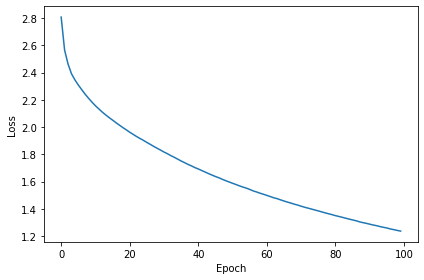

In [9]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp1_W1_trained, W1_bis, Exp1_W2_trained, Exp1_snn_training_snapshot, single_neuron_model = train(ipds_train, spikes_train,
                                                                                         multiple_connections_per_axon=False)


Train classifier accuracy: 63.3%
Train absolute error: 7.2 deg

Test classifier accuracy: 57.3%
Test absolute error: 7.8 deg


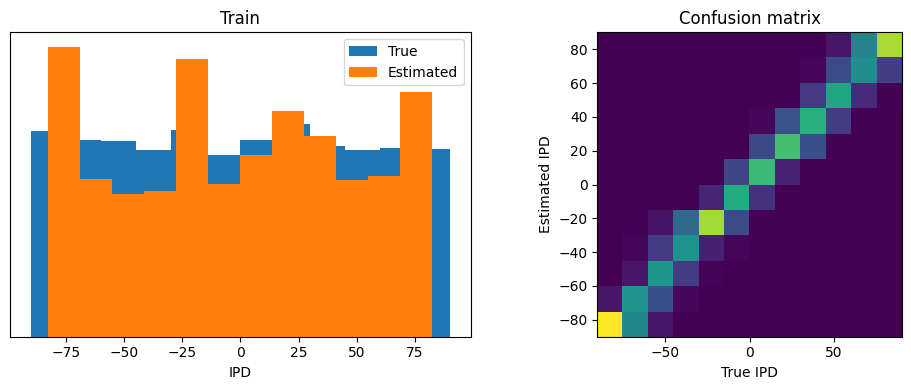

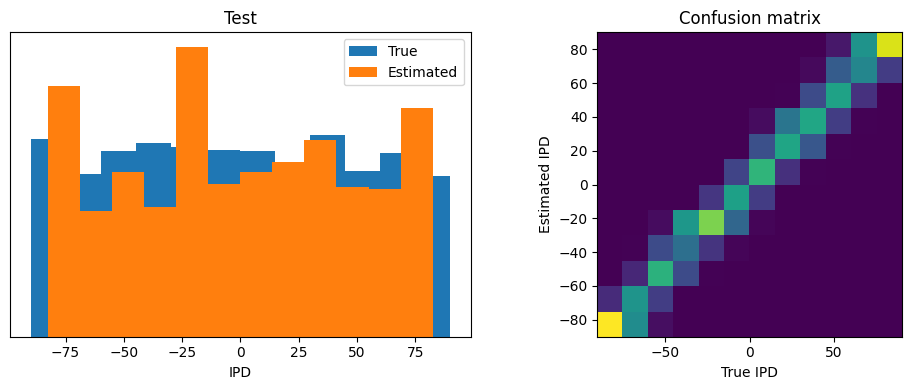

In [10]:
# training and testing accuracies
Exp1Fast_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                           multiple_connections_per_axon=False, single_neuron_model=single_neuron_model,
                                           test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp1_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                          multiple_connections_per_axon=False, single_neuron_model=single_neuron_model,
                                          test_data=True)

## Exp 2. Training & Testing Results

### Using multiple connections (M=3)

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1


  1%|          | 1/100 [00:09<16:14,  9.85s/it]

---EPOCH 1: LOSS=2.77975
--------------------------------------------------------
EPOCH 2


  2%|▏         | 2/100 [00:19<15:33,  9.53s/it]

---EPOCH 2: LOSS=2.48943
--------------------------------------------------------
EPOCH 3


  3%|▎         | 3/100 [00:28<15:03,  9.31s/it]

---EPOCH 3: LOSS=2.43309
--------------------------------------------------------
EPOCH 4


  4%|▍         | 4/100 [00:37<14:55,  9.33s/it]

---EPOCH 4: LOSS=2.39790
--------------------------------------------------------
EPOCH 5


  5%|▌         | 5/100 [00:47<14:52,  9.39s/it]

---EPOCH 5: LOSS=2.36529
--------------------------------------------------------
EPOCH 6


  6%|▌         | 6/100 [00:55<14:24,  9.20s/it]

---EPOCH 6: LOSS=2.33296
--------------------------------------------------------
EPOCH 7


  7%|▋         | 7/100 [01:04<14:06,  9.10s/it]

---EPOCH 7: LOSS=2.30643
--------------------------------------------------------
EPOCH 8


  8%|▊         | 8/100 [01:13<13:55,  9.09s/it]

---EPOCH 8: LOSS=2.28021
--------------------------------------------------------
EPOCH 9


  9%|▉         | 9/100 [01:22<13:34,  8.95s/it]

---EPOCH 9: LOSS=2.25632
--------------------------------------------------------
EPOCH 10


 10%|█         | 10/100 [01:31<13:14,  8.83s/it]

---EPOCH 10: LOSS=2.23011
--------------------------------------------------------
EPOCH 11


 11%|█         | 11/100 [01:39<13:08,  8.86s/it]

---EPOCH 11: LOSS=2.20565
--------------------------------------------------------
EPOCH 12


 12%|█▏        | 12/100 [01:49<13:10,  8.99s/it]

---EPOCH 12: LOSS=2.18536
--------------------------------------------------------
EPOCH 13


 13%|█▎        | 13/100 [01:58<13:07,  9.05s/it]

---EPOCH 13: LOSS=2.15993
--------------------------------------------------------
EPOCH 14


 14%|█▍        | 14/100 [02:08<13:13,  9.23s/it]

---EPOCH 14: LOSS=2.13865
--------------------------------------------------------
EPOCH 15


 15%|█▌        | 15/100 [02:17<13:19,  9.40s/it]

---EPOCH 15: LOSS=2.11837
--------------------------------------------------------
EPOCH 16


 16%|█▌        | 16/100 [02:27<13:15,  9.47s/it]

---EPOCH 16: LOSS=2.09663
--------------------------------------------------------
EPOCH 17


 17%|█▋        | 17/100 [02:36<13:03,  9.44s/it]

---EPOCH 17: LOSS=2.07650
--------------------------------------------------------
EPOCH 18


 18%|█▊        | 18/100 [02:46<12:52,  9.42s/it]

---EPOCH 18: LOSS=2.05805
--------------------------------------------------------
EPOCH 19


 19%|█▉        | 19/100 [02:56<12:50,  9.52s/it]

---EPOCH 19: LOSS=2.03774
--------------------------------------------------------
EPOCH 20


 20%|██        | 20/100 [03:05<12:40,  9.50s/it]

---EPOCH 20: LOSS=2.01751
--------------------------------------------------------
EPOCH 21


 21%|██        | 21/100 [03:15<12:32,  9.52s/it]

---EPOCH 21: LOSS=1.99678
--------------------------------------------------------
EPOCH 22


 22%|██▏       | 22/100 [03:24<12:32,  9.65s/it]

---EPOCH 22: LOSS=1.97186
--------------------------------------------------------
EPOCH 23


 23%|██▎       | 23/100 [03:34<12:22,  9.64s/it]

---EPOCH 23: LOSS=1.95140
--------------------------------------------------------
EPOCH 24


 24%|██▍       | 24/100 [03:43<11:51,  9.36s/it]

---EPOCH 24: LOSS=1.93431
--------------------------------------------------------
EPOCH 25


 25%|██▌       | 25/100 [03:52<11:47,  9.43s/it]

---EPOCH 25: LOSS=1.91304
--------------------------------------------------------
EPOCH 26


 26%|██▌       | 26/100 [04:02<11:42,  9.49s/it]

---EPOCH 26: LOSS=1.89475
--------------------------------------------------------
EPOCH 27


 27%|██▋       | 27/100 [04:13<11:59,  9.86s/it]

---EPOCH 27: LOSS=1.87521
--------------------------------------------------------
EPOCH 28


 28%|██▊       | 28/100 [04:23<11:49,  9.85s/it]

---EPOCH 28: LOSS=1.85788
--------------------------------------------------------
EPOCH 29


 29%|██▉       | 29/100 [04:32<11:34,  9.78s/it]

---EPOCH 29: LOSS=1.84079
--------------------------------------------------------
EPOCH 30


 30%|███       | 30/100 [04:41<11:08,  9.55s/it]

---EPOCH 30: LOSS=1.82494
--------------------------------------------------------
EPOCH 31


 31%|███       | 31/100 [04:50<10:45,  9.36s/it]

---EPOCH 31: LOSS=1.80928
--------------------------------------------------------
EPOCH 32


 32%|███▏      | 32/100 [04:59<10:24,  9.18s/it]

---EPOCH 32: LOSS=1.79311
--------------------------------------------------------
EPOCH 33


 33%|███▎      | 33/100 [05:08<10:07,  9.07s/it]

---EPOCH 33: LOSS=1.77583
--------------------------------------------------------
EPOCH 34


 34%|███▍      | 34/100 [05:17<09:57,  9.06s/it]

---EPOCH 34: LOSS=1.75982
--------------------------------------------------------
EPOCH 35


 35%|███▌      | 35/100 [05:26<09:45,  9.00s/it]

---EPOCH 35: LOSS=1.74054
--------------------------------------------------------
EPOCH 36


 36%|███▌      | 36/100 [05:34<09:29,  8.89s/it]

---EPOCH 36: LOSS=1.72292
--------------------------------------------------------
EPOCH 37


 37%|███▋      | 37/100 [05:43<09:21,  8.91s/it]

---EPOCH 37: LOSS=1.70417
--------------------------------------------------------
EPOCH 38


 38%|███▊      | 38/100 [05:52<09:10,  8.87s/it]

---EPOCH 38: LOSS=1.68707
--------------------------------------------------------
EPOCH 39


 39%|███▉      | 39/100 [06:01<08:59,  8.85s/it]

---EPOCH 39: LOSS=1.67016
--------------------------------------------------------
EPOCH 40


 40%|████      | 40/100 [06:10<09:03,  9.06s/it]

---EPOCH 40: LOSS=1.65586
--------------------------------------------------------
EPOCH 41


 41%|████      | 41/100 [06:19<08:55,  9.07s/it]

---EPOCH 41: LOSS=1.64253
--------------------------------------------------------
EPOCH 42


 42%|████▏     | 42/100 [06:28<08:45,  9.06s/it]

---EPOCH 42: LOSS=1.62788
--------------------------------------------------------
EPOCH 43


 43%|████▎     | 43/100 [06:37<08:31,  8.97s/it]

---EPOCH 43: LOSS=1.61478
--------------------------------------------------------
EPOCH 44


 44%|████▍     | 44/100 [06:46<08:20,  8.94s/it]

---EPOCH 44: LOSS=1.60126
--------------------------------------------------------
EPOCH 45


 45%|████▌     | 45/100 [06:55<08:11,  8.94s/it]

---EPOCH 45: LOSS=1.59007
--------------------------------------------------------
EPOCH 46


 46%|████▌     | 46/100 [07:04<08:00,  8.89s/it]

---EPOCH 46: LOSS=1.57802
--------------------------------------------------------
EPOCH 47


 47%|████▋     | 47/100 [07:13<07:51,  8.90s/it]

---EPOCH 47: LOSS=1.56665
--------------------------------------------------------
EPOCH 48


 48%|████▊     | 48/100 [07:22<07:40,  8.86s/it]

---EPOCH 48: LOSS=1.55513
--------------------------------------------------------
EPOCH 49


 49%|████▉     | 49/100 [07:30<07:31,  8.85s/it]

---EPOCH 49: LOSS=1.54493
--------------------------------------------------------
EPOCH 50


 50%|█████     | 50/100 [07:39<07:19,  8.79s/it]

---EPOCH 50: LOSS=1.53372
--------------------------------------------------------
EPOCH 51


 51%|█████     | 51/100 [07:48<07:07,  8.72s/it]

---EPOCH 51: LOSS=1.52248
--------------------------------------------------------
EPOCH 52


 52%|█████▏    | 52/100 [07:56<06:59,  8.75s/it]

---EPOCH 52: LOSS=1.51212
--------------------------------------------------------
EPOCH 53


 53%|█████▎    | 53/100 [08:06<07:01,  8.97s/it]

---EPOCH 53: LOSS=1.50200
--------------------------------------------------------
EPOCH 54


 54%|█████▍    | 54/100 [08:15<07:01,  9.17s/it]

---EPOCH 54: LOSS=1.49226
--------------------------------------------------------
EPOCH 55


 55%|█████▌    | 55/100 [08:25<06:57,  9.28s/it]

---EPOCH 55: LOSS=1.48441
--------------------------------------------------------
EPOCH 56


 56%|█████▌    | 56/100 [08:34<06:41,  9.13s/it]

---EPOCH 56: LOSS=1.47373
--------------------------------------------------------
EPOCH 57


 57%|█████▋    | 57/100 [08:43<06:31,  9.11s/it]

---EPOCH 57: LOSS=1.46426
--------------------------------------------------------
EPOCH 58


 58%|█████▊    | 58/100 [08:52<06:22,  9.11s/it]

---EPOCH 58: LOSS=1.45492
--------------------------------------------------------
EPOCH 59


 59%|█████▉    | 59/100 [09:01<06:15,  9.15s/it]

---EPOCH 59: LOSS=1.44661
--------------------------------------------------------
EPOCH 60


 60%|██████    | 60/100 [09:10<06:03,  9.09s/it]

---EPOCH 60: LOSS=1.43711
--------------------------------------------------------
EPOCH 61


 61%|██████    | 61/100 [09:20<06:03,  9.31s/it]

---EPOCH 61: LOSS=1.42963
--------------------------------------------------------
EPOCH 62


 62%|██████▏   | 62/100 [09:29<05:47,  9.15s/it]

---EPOCH 62: LOSS=1.42165
--------------------------------------------------------
EPOCH 63


 63%|██████▎   | 63/100 [09:38<05:36,  9.09s/it]

---EPOCH 63: LOSS=1.41403
--------------------------------------------------------
EPOCH 64


 64%|██████▍   | 64/100 [09:48<05:45,  9.60s/it]

---EPOCH 64: LOSS=1.40536
--------------------------------------------------------
EPOCH 65


 65%|██████▌   | 65/100 [09:59<05:44,  9.85s/it]

---EPOCH 65: LOSS=1.39788
--------------------------------------------------------
EPOCH 66


 66%|██████▌   | 66/100 [10:10<05:43, 10.11s/it]

---EPOCH 66: LOSS=1.39010
--------------------------------------------------------
EPOCH 67


 67%|██████▋   | 67/100 [10:20<05:37, 10.24s/it]

---EPOCH 67: LOSS=1.38253
--------------------------------------------------------
EPOCH 68


 68%|██████▊   | 68/100 [10:31<05:31, 10.37s/it]

---EPOCH 68: LOSS=1.37322
--------------------------------------------------------
EPOCH 69


 69%|██████▉   | 69/100 [10:44<05:45, 11.15s/it]

---EPOCH 69: LOSS=1.36716
--------------------------------------------------------
EPOCH 70


 70%|███████   | 70/100 [10:56<05:42, 11.40s/it]

---EPOCH 70: LOSS=1.35901
--------------------------------------------------------
EPOCH 71


 71%|███████   | 71/100 [11:08<05:36, 11.60s/it]

---EPOCH 71: LOSS=1.35109
--------------------------------------------------------
EPOCH 72


 72%|███████▏  | 72/100 [11:21<05:33, 11.92s/it]

---EPOCH 72: LOSS=1.34413
--------------------------------------------------------
EPOCH 73


 73%|███████▎  | 73/100 [11:30<05:03, 11.24s/it]

---EPOCH 73: LOSS=1.33700
--------------------------------------------------------
EPOCH 74


 74%|███████▍  | 74/100 [11:40<04:37, 10.69s/it]

---EPOCH 74: LOSS=1.33069
--------------------------------------------------------
EPOCH 75


 75%|███████▌  | 75/100 [11:49<04:16, 10.28s/it]

---EPOCH 75: LOSS=1.32303
--------------------------------------------------------
EPOCH 76


 76%|███████▌  | 76/100 [12:00<04:09, 10.41s/it]

---EPOCH 76: LOSS=1.31761
--------------------------------------------------------
EPOCH 77


 77%|███████▋  | 77/100 [12:09<03:55, 10.22s/it]

---EPOCH 77: LOSS=1.30953
--------------------------------------------------------
EPOCH 78


 78%|███████▊  | 78/100 [12:19<03:40, 10.04s/it]

---EPOCH 78: LOSS=1.30399
--------------------------------------------------------
EPOCH 79


 79%|███████▉  | 79/100 [12:29<03:30, 10.01s/it]

---EPOCH 79: LOSS=1.29726
--------------------------------------------------------
EPOCH 80


 80%|████████  | 80/100 [12:39<03:20, 10.04s/it]

---EPOCH 80: LOSS=1.29030
--------------------------------------------------------
EPOCH 81


 81%|████████  | 81/100 [12:50<03:17, 10.39s/it]

---EPOCH 81: LOSS=1.28427
--------------------------------------------------------
EPOCH 82


 82%|████████▏ | 82/100 [13:00<03:04, 10.25s/it]

---EPOCH 82: LOSS=1.27807
--------------------------------------------------------
EPOCH 83


 83%|████████▎ | 83/100 [13:10<02:52, 10.13s/it]

---EPOCH 83: LOSS=1.27155
--------------------------------------------------------
EPOCH 84


 84%|████████▍ | 84/100 [13:20<02:39,  9.96s/it]

---EPOCH 84: LOSS=1.26524
--------------------------------------------------------
EPOCH 85


 85%|████████▌ | 85/100 [13:29<02:25,  9.73s/it]

---EPOCH 85: LOSS=1.26003
--------------------------------------------------------
EPOCH 86


 86%|████████▌ | 86/100 [13:38<02:14,  9.59s/it]

---EPOCH 86: LOSS=1.25504
--------------------------------------------------------
EPOCH 87


 87%|████████▋ | 87/100 [13:47<02:03,  9.53s/it]

---EPOCH 87: LOSS=1.24881
--------------------------------------------------------
EPOCH 88


 88%|████████▊ | 88/100 [13:57<01:53,  9.46s/it]

---EPOCH 88: LOSS=1.24128
--------------------------------------------------------
EPOCH 89


 89%|████████▉ | 89/100 [14:07<01:46,  9.65s/it]

---EPOCH 89: LOSS=1.23756
--------------------------------------------------------
EPOCH 90


 90%|█████████ | 90/100 [14:18<01:40, 10.03s/it]

---EPOCH 90: LOSS=1.23236
--------------------------------------------------------
EPOCH 91


 91%|█████████ | 91/100 [14:27<01:29,  9.91s/it]

---EPOCH 91: LOSS=1.22519
--------------------------------------------------------
EPOCH 92


 92%|█████████▏| 92/100 [14:37<01:17,  9.73s/it]

---EPOCH 92: LOSS=1.22161
--------------------------------------------------------
EPOCH 93


 93%|█████████▎| 93/100 [14:46<01:06,  9.51s/it]

---EPOCH 93: LOSS=1.21654
--------------------------------------------------------
EPOCH 94


 94%|█████████▍| 94/100 [14:55<00:57,  9.54s/it]

---EPOCH 94: LOSS=1.21127
--------------------------------------------------------
EPOCH 95


 95%|█████████▌| 95/100 [15:05<00:47,  9.45s/it]

---EPOCH 95: LOSS=1.20618
--------------------------------------------------------
EPOCH 96


 96%|█████████▌| 96/100 [15:14<00:37,  9.45s/it]

---EPOCH 96: LOSS=1.20015
--------------------------------------------------------
EPOCH 97


 97%|█████████▋| 97/100 [15:23<00:28,  9.38s/it]

---EPOCH 97: LOSS=1.19487
--------------------------------------------------------
EPOCH 98


 98%|█████████▊| 98/100 [15:32<00:18,  9.31s/it]

---EPOCH 98: LOSS=1.19023
--------------------------------------------------------
EPOCH 99


 99%|█████████▉| 99/100 [15:42<00:09,  9.33s/it]

---EPOCH 99: LOSS=1.18684
--------------------------------------------------------
EPOCH 100


100%|██████████| 100/100 [15:51<00:00,  9.52s/it]

---EPOCH 100: LOSS=1.18137


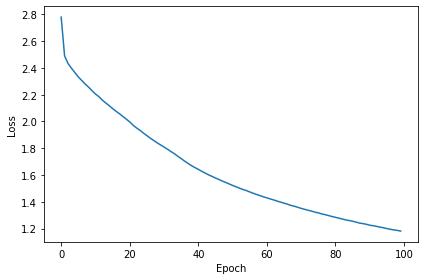

In [11]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp2_W1_trained, W1_bis, Exp2_W2_trained, Exp2_snn_training_snapshot, single_neuron_model = train(ipds_train, spikes_train,
                                                                                         multiple_connections_per_axon=True)


Train classifier accuracy: 65.6%
Train absolute error: 6.9 deg

Test classifier accuracy: 31.1%
Test absolute error: 16.9 deg


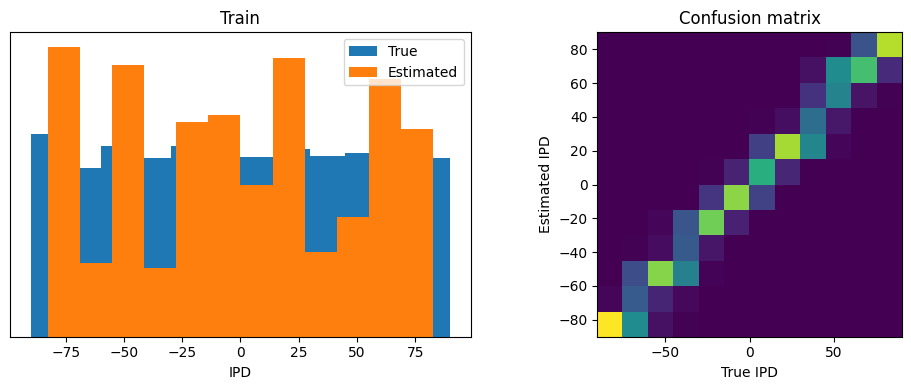

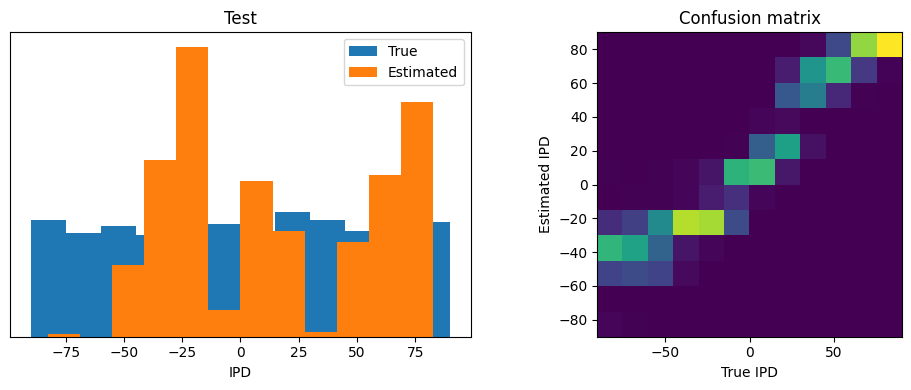

In [12]:
# training and testing accuracies
Exp2_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp2_W1_trained, W1_bis, Exp2_W2_trained, 
                                           multiple_connections_per_axon=True, single_neuron_model=single_neuron_model,
                                           test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp2_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp2_W1_trained, W1_bis, Exp2_W2_trained, 
                                          multiple_connections_per_axon=True, single_neuron_model=single_neuron_model,
                                          test_data=True)

## Results

Currently the model with the multiple contacts (here M=3), achieves marginally better training accuracy (65.6%) than the training accuracy (63.3%) of the no multiple contacts model (M=1), but its test accuracy is much worse (57.3% vs 31.1%).

However, it seems that the multiple contacts model overfits to the data.
We should possibly add some regularization means, or check out the hyper-parameters we are using.